In [99]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA,FastICA
from sklearn.cluster import MeanShift, estimate_bandwidth

In [100]:
def spli_matrix_two_blocks(y, percentage1, percentage2, seed):
    if(percentage1+percentage2==1):
        num_row = len(y)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
    

In [101]:
def feature_extraction(signal,feature_dictionary,f_peak,prototype_no_oxy,prototype_yes_oxy,indipendent_components):
    feature=[]
    
    if(feature_dictionary["fft_max_frequencies"]==1):
        feature=np.concatenate((feature,f_peak.reshape(f_peak.shape[1])), axis=0);

    if(feature_dictionary["distance_from_prototype"]==1):
        d_from_no=np.sum(np.square(signal-prototype_no_oxy))
        d_from_yes=np.sum(np.square(signal-prototype_yes_oxy))
        feature=np.concatenate((feature,[d_from_no]), axis=0)
        feature=np.concatenate((feature,[d_from_yes]), axis=0)
        
    if(feature_dictionary["distance_from_ica"]==1):
        distances_from_ica=np.ones(len(indipendent_components));
        for single_component in indipendent_components;
            
        
        
    if(feature_dictionary["mean"]==1):
        mean=np.mean(signal);
        feature=np.concatenate((feature,[mean]), axis=0)
    
    if(feature_dictionary["variance"]==1):
        variance=np.var(signal)
        feature=np.concatenate((feature,[variance]), axis=0)
    #crest factor 
    if(feature_dictionary["crest_factor"]==1):
        crest_factor=np.sum(np.power(signal,2))/signal.size
        feature=np.concatenate((feature,[crest_factor]), axis=0)
    
    return np.asarray(feature)
#.reshape([feature.size,1])

def extract_ICs(channel_structure,n_ICA_components):
    ica = FastICA(n_components=n_ICA_components,max_iter=1000)
    S_ = ica.fit_transform(channel_structure)  
    return S_
    
def extract_prototype(channel_structure,n_PCA_components):
    channel_structure_new=[];
    #using PCA 
    for time_instace in channel_structure:
        pca = PCA(n_components=n_PCA_components)
        time_instace_reduced=pca.fit_transform(time_instace.T);
        channel_structure_new.append(time_instace_reduced.T);
    
  
    channel_structure_new=np.concatenate(channel_structure_new,axis=0);

    # dim(channels_structure_new) = "number_of_reduced_sample" X "time_lenght"
    # if n_components=1 =" 30 X 80

    bandwidth = estimate_bandwidth(channel_structure_new, quantile=0.2, n_samples=len(channel_structure_new));
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True);
    ms.fit(channel_structure_new)
    prototype= ms.cluster_centers_
    return prototype.T



In [183]:
def export_signals(channels):
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    # for NIRS signal ==80 
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   

    return time_instances;



def get_feature_matrix_and_labels(channel_structure, feature_dictionary,label,features_extracted,n_ICA_components):
    list_train=[]
    list_labels=[]
    list_row=[]
    cont=0;
    peak_signal=features_extracted["peak_signal"]
    f_peak_signal=peak_signal["f_cell"];
    prototype_no_oxy=features_extracted["prototype_no_oxy"]
    prototype_yes_oxy=features_extracted["prototype_yes_oxy"]
    
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
            features=feature_extraction(time_instance[j,:],feature_dictionary,f_peak_signal[0,cont],prototype_no_oxy,prototype_yes_oxy,indipendent_components)
            list_row.append(features);
            cont=cont+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]

    
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


def get_feature_matrix(channels,feature_dictionary,features_extracted):
    list_train=[]
    list_labels=[]
    cont=0;
    peak_signal=features_extracted["peak_signal"]
    f_peak_signal=peak_signal["f_cell"];
    prototype_no_oxy=features_extracted["prototype_no_oxy"]
    prototype_yes_oxy=features_extracted["prototype_yes_oxy"]
    
    for time_instance in channel_structure:
        dim1=time_instace.shape
        print(dim1)
        for j  in range (0,dim1[0]):
            features=feature_extraction(time_instance[j,:],feature_dictionary,f_peak_signal[0,cont],prototype_no_oxy,prototype_yes_oxy)
            list_train.append([features]);
            cont=cont+1;
    train_TX=np.concatenate(list_train)
    return train_TX

def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    
    
    
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix
            
        
    

# OXY SIGNALS

PROTOTYPE OF YES


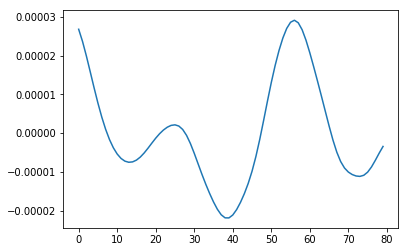

PROTOTYPE OF NO


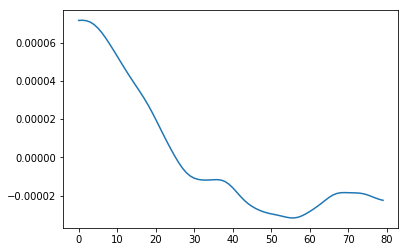

/Users/matteociprian/anaconda/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Train matrix shape
(60, 90)
Label array shape
(60,)


In [172]:
#parameters
n_ica_components=3;

#buildig the train matrix and labels
yes_oxy_contents = sio.loadmat('./segnali_belli/NIRSoxy_yesFasato.mat')
no_oxy_contents = sio.loadmat('./segnali_belli/NIRSoxy_noFasato.mat')
channels_no=no_oxy_contents["nofasato"]
channels_yes=yes_oxy_contents["yesfasato"]


#peak on NIRS
peak_yes_oxy_contents = sio.loadmat('pick_NIRSOxy_yes_signal.mat')
peak_no_oxy_contents = sio.loadmat('pick_NIRSoxy_no_signal.mat')

#explore with Mean_shift


# yes signals
channels_structure_yes_OXY=export_signals(channels_yes)
prototype_yes_oxy= extract_prototype(channels_structure_yes_OXY,2)
print("PROTOTYPE OF YES")
plt.plot(prototype_yes_oxy)
plt.show()

# no signals
channels_structure_no_OXY=export_signals(channels_no)
prototype_no_oxy= extract_prototype(channels_structure_no_OXY,2)
print("PROTOTYPE OF NO")
plt.plot(prototype_no_oxy)
plt.show()
    #select which feature select
    
feature_dictionary = {
        "fft_max_frequencies" : 1, 
         "mean" : 1, 
         "variance" : 1,
         "crest_factor" : 1,
         "distance_from_prototype": 0,
         "distance_from_ica": 1
         }


features_extracted={
    "peak_signal" : peak_yes_oxy_contents,
    "prototype_no_oxy" : prototype_no_oxy,
    "prototype_yes_oxy" : prototype_yes_oxy
}


train_TX_yes_oxy,labels_yes=get_feature_matrix_and_labels(channels_structure_yes_OXY, feature_dictionary,"Yes",features_extracted,n_ica_components);


features_extracted={
    "peak_signal" : peak_no_oxy_contents,
    "prototype_no_oxy" : prototype_no_oxy,
    "prototype_yes_oxy" : prototype_yes_oxy
}
train_TX_no_oxy,labels_no=get_feature_matrix_and_labels(channels_structure_no_OXY, feature_dictionary,"No",features_extracted,n_ica_components);
train_TX=np.concatenate((train_TX_yes_oxy,train_TX_no_oxy,),axis=0)

print("Train matrix shape")
print(train_TX.shape)

labels=np.concatenate((labels_yes,labels_no),axis=0)
print("Label array shape")
print(labels.shape)

In [173]:
# REGULARIZATION
degrees = np.array([1])
lambdas = np.logspace(-8,-2,6)
k_fold=10
seed = 2
max_iters = 5000
print(train_TX.shape)

best_deg,best_lambda, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_logistic_regularized(labels,train_TX, degrees, lambdas, k_fold, seed, max_iters)


(60, 90)
--- Fold 0 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
0.5
>> Lambda 1.58489319246e-07 <<
0.5
>> Lambda 2.51188643151e-06 <<
0.5
>> Lambda 3.98107170553e-05 <<
0.5
>> Lambda 0.00063095734448 <<
0.5
>> Lambda 0.01 <<
0.5
--- Fold 1 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
0.666666666667
>> Lambda 1.58489319246e-07 <<
0.666666666667
>> Lambda 2.51188643151e-06 <<
0.666666666667
>> Lambda 3.98107170553e-05 <<
0.666666666667
>> Lambda 0.00063095734448 <<
0.833333333333
>> Lambda 0.01 <<
0.833333333333
--- Fold 2 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
0.5
>> Lambda 1.58489319246e-07 <<
0.5
>> Lambda 2.51188643151e-06 <<
0.666666666667
>> Lambda 3.98107170553e-05 <<
0.5
>> Lambda 0.00063095734448 <<
0.833333333333
>> Lambda 0.01 <<
0.833333333333
--- Fold 3 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
0.5
>> Lambda 1.58489319246e-07 <<
0.5
>> Lambda 2.51188643151e-06 <<
0.5
>> Lambda 3.98107170553e-05 <<
0.5
>> Lambda 0.00063095734448 <<
0.5
>> Lambda 0.01 <<
0.5
--- Fold 4 ---
++ Degree 1 ++
>> Lam

0.555555555556


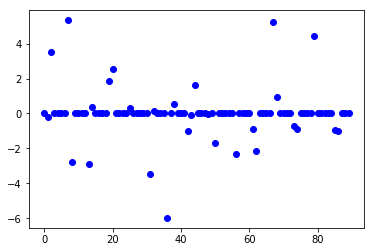

[ 0.         -0.22108232  3.53660541  0.          0.          0.          0.
  5.33895469 -2.78579554  0.          0.          0.          0.
 -2.91453446  0.34312424  0.          0.          0.          0.          1.8401397
  2.57390488  0.          0.          0.          0.          0.33272719
  0.          0.          0.          0.          0.         -3.47324516
  0.16107364  0.          0.          0.         -5.9845035   0.
  0.53322039  0.          0.          0.         -1.0217923  -0.10237648
  1.64794886  0.          0.          0.         -0.03214003  0.         -1.6663866
  0.          0.          0.          0.          0.         -2.33358899
  0.          0.          0.          0.         -0.88931696 -2.1255752   0.
  0.          0.          0.          5.21761223  0.92793408  0.          0.
  0.          0.         -0.74171071 -0.87301025  0.          0.          0.
  0.          4.45361206  0.          0.          0.          0.          0.
 -0.95461097 -1.02265958 

In [174]:
#LOGISTIC 

max_iters = 100000
[i1,i2]=spli_matrix_two_blocks(train_TX,0.7,0.3,2)

# TRAIN SET 

train=train_TX[i1,:]
labels_train=labels[i1]

# TEST SET
test= train_TX[i2,:]
labels_test=labels[i2]




logreg = linear_model.LogisticRegression(penalty='l1',C=1/best_lambda,max_iter=max_iters)


logreg.fit(train, labels_train)  
predicted_labels= logreg.predict(test)


logistic_accuracy=get_accuracy(predicted_labels, labels_test)
print(logistic_accuracy)

plt.plot(logreg.coef_[0],'bo')
plt.show()
print(logreg.coef_[0])
th=np.mean(np.abs(logreg.coef_[0]/10))

train_TX=select_features(logreg.coef_[0],train_TX,th)

print(train_TX.shape)

# SVM on oxy

In [175]:

C_parameters= np.linspace(0.1,10,10)
k_fold=4 # number of k sub-folders to divide the set
seed = 1
max_iters = 10000
kernel_types=['linear', 'rbf', 'sigmoid']
print(train_TX.shape)
best_C, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels,train_TX, C_parameters, kernel_types, k_fold, seed, max_iters)



(60, 12)
--- Fold 0 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.4 0.8
>> Type of Kernel  rbf <<
0.333333333333 0.555555555556
>> Type of Kernel  sigmoid <<
0.333333333333 0.555555555556
>> Penalty parameter C 1.2 <<
>> Type of Kernel  linear <<
0.4 0.844444444444
>> Type of Kernel  rbf <<
0.466666666667 0.933333333333
>> Type of Kernel  sigmoid <<
0.333333333333 0.6
>> Penalty parameter C 2.3 <<
>> Type of Kernel  linear <<
0.4 0.822222222222
>> Type of Kernel  rbf <<
0.466666666667 0.977777777778
>> Type of Kernel  sigmoid <<
0.333333333333 0.533333333333
>> Penalty parameter C 3.4 <<
>> Type of Kernel  linear <<
0.4 0.844444444444
>> Type of Kernel  rbf <<
0.466666666667 1.0
>> Type of Kernel  sigmoid <<
0.266666666667 0.555555555556
>> Penalty parameter C 4.5 <<
>> Type of Kernel  linear <<
0.4 0.844444444444
>> Type of Kernel  rbf <<
0.466666666667 1.0
>> Type of Kernel  sigmoid <<
0.333333333333 0.555555555556
>> Penalty parameter C 5.6 <<
>> Type of Kernel  l

In [182]:
from sklearn import svm


[i1,i2]=spli_matrix_two_blocks(train_TX,0.1,0.9,3)

# TRAIN SET 

train=train_TX[i1,:]
labels_train=labels[i1]

# TEST SET
test= train_TX[i2,:]
labels_test=labels[i2]

clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


clf.fit(train, labels_train)  
predicted_labels= clf.predict(test)


SVM_accuracy=get_accuracy(predicted_labels, labels_test)
print(SVM_accuracy)

0.518518518519
